In [1]:
%pip install scipy pandas numpy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
from scipy.stats import pearsonr

df = pd.read_csv('/workspaces/ticket-heroes/ticket-prophet/data/processed/CLEAN_artists_spotify_lastfm.csv') 

# Define the Target
TARGET_VARIABLE = 'avg_track_popularity' 

# Drop target variables and numerical
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
if TARGET_VARIABLE in numerical_features:
    numerical_features.remove(TARGET_VARIABLE)

# Store as a tuple
correlation_results = []

for feature in numerical_features:
    temp_df = df[[feature, TARGET_VARIABLE]].dropna()

    if len(temp_df) > 1:
        # pearsonr returns (correlation_coefficient, p_value)
        correlation_coeff, p_value = pearsonr(temp_df[feature], temp_df[TARGET_VARIABLE])
        correlation_results.append((feature, correlation_coeff))
    else:
        # Handle features with too few non-null data points
        correlation_results.append((feature, 0.0)) 

# New DF
corr_df = pd.DataFrame(correlation_results, columns=['Feature', 'Correlation_r'])

# Calculate the absolute correlation for ranking importance
corr_df['Abs_Correlation'] = corr_df['Correlation_r'].abs()

# Sort by Desc
ranked_features = corr_df.sort_values(by='Abs_Correlation', ascending=False).reset_index(drop=True)

print(f"### Top 20 Features Ranked by Pearson Correlation to {TARGET_VARIABLE} ###")
print(ranked_features.head(20))

# Select for model
N = 15
top_N_features = ranked_features.head(N)['Feature'].tolist()

print(f"\n--- Selected Top {N} Features ---")
print(top_N_features)

### Top 20 Features Ranked by Pearson Correlation to avg_track_popularity ###
              Feature  Correlation_r  Abs_Correlation
0   artist_popularity       0.602224         0.602224
1    lastfm_listeners       0.387161         0.387161
2    artist_followers       0.221207         0.221207
3    lastfm_playcount       0.203558         0.203558
4  plays_per_listener       0.196018         0.196018
5  avg_track_duration       0.153214         0.153214
6      explicit_ratio       0.095943         0.095943
7        total_tracks       0.089097         0.089097

--- Selected Top 15 Features ---
['artist_popularity', 'lastfm_listeners', 'artist_followers', 'lastfm_playcount', 'plays_per_listener', 'avg_track_duration', 'explicit_ratio', 'total_tracks']


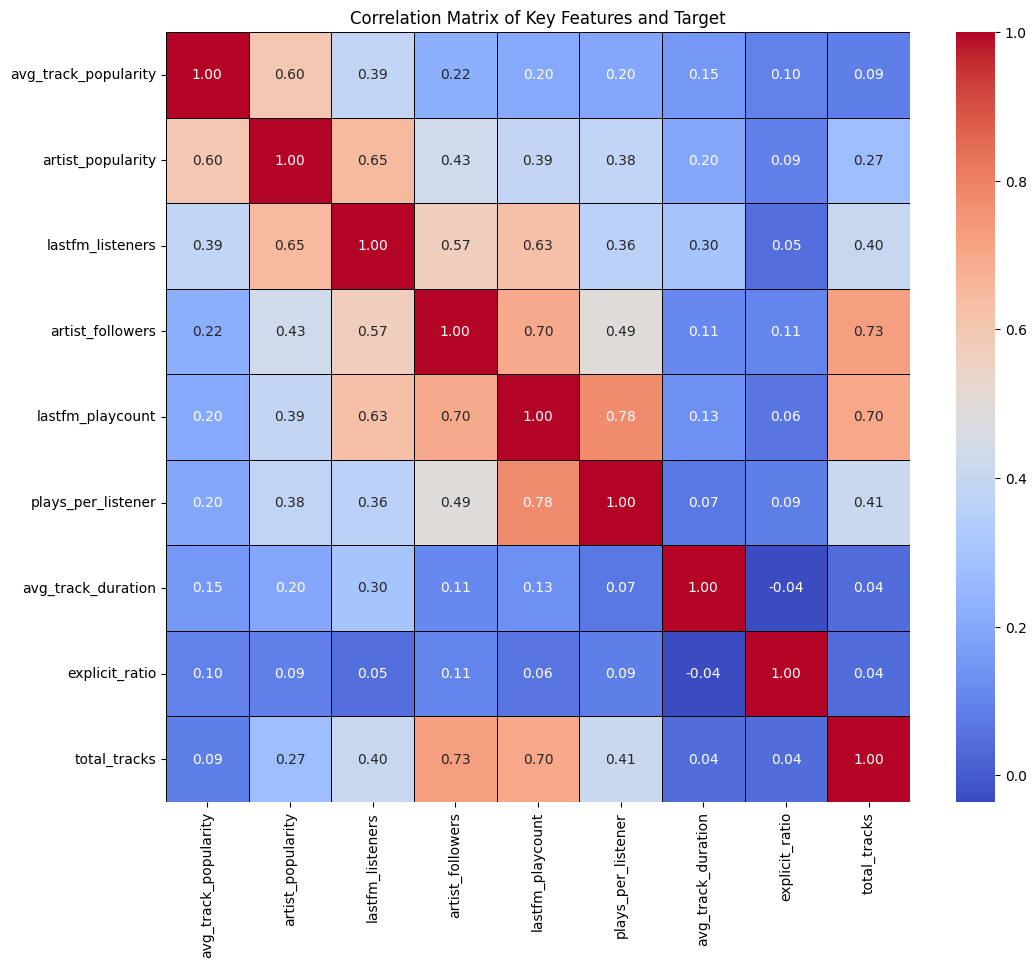


### High Correlation Check (Multicollinearity) ###
No highly correlated feature pairs found (r >= 0.8).


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


TARGET_VARIABLE = 'avg_track_popularity' 


top_N_features = ranked_features.head(N)['Feature'].tolist()


key_columns_to_include = [TARGET_VARIABLE] + top_N_features


df_matrix = df[key_columns_to_include].copy().dropna() # Drop NaN for clean calculation

# The .corr() method calculates the Pearson 'r' matrix by default.
correlation_matrix = df_matrix.corr(method='pearson')


# 4. Visualize the Correlation Matrix using a Heatmap
plt.figure(figsize=(12, 10))

# 'cmap='coolwarm'' to show both positive and negative correlations.
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True, 
    linewidths=.5, 
    linecolor='black'
)
plt.title('Correlation Matrix of Key Features and Target')
plt.show() 


# Check for Multicollinearity
print("\n### High Correlation Check (Multicollinearity) ###")
# Find pairs of features (excluding the target) with a correlation > 0.8 (or your chosen threshold)

high_corr_threshold = 0.8
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

highly_correlated_pairs = upper_triangle.unstack().sort_values(ascending=False)
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs.abs() >= high_corr_threshold]

if highly_correlated_pairs.empty:
    print("No highly correlated feature pairs found (r >= 0.8).")
else:
    print("Feature pairs with high correlation (potential multicollinearity):")
    print(highly_correlated_pairs)